### Used libraries

In [1]:
import numpy as np
import scipy as sp
from skimage.draw import line_nd
import cv2
from copy import deepcopy
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets as widgets
from skimage.exposure import rescale_intensity

matplotlib.rcParams['figure.figsize'] = [8, 8]


### Chosing path to a file and parameters

In [2]:
wdg_path = widgets.Text(value='./example_photos/Kropka.jpg', placeholder='Type path to a file', description='Path to a file:')
wdg_scans = widgets.IntSlider(value=90, min=90, max=720, step = 90, description='Number of scans:')
wdg_detectors = widgets.IntSlider(value=180, min=90, max=720, step = 90, description='Number of detectors:')
wdg_kernel_size = widgets.IntSlider(value=11, min=1, max=101, step = 2, description='Kernel size:')
wdg_opening = widgets.IntSlider(value=135, min=45, max=270, step = 45, description='Opening width:')
wdg_display_steps = widgets.Checkbox(value=True,description='Show steps:',disabled=False,indent=False)

display(wdg_path)
display(wdg_scans)
display(wdg_detectors)
display(wdg_opening)
display(wdg_kernel_size)
display(wdg_display_steps)

Text(value='./example_photos/Kropka.jpg', description='Path to a file:', placeholder='Type path to a file')

IntSlider(value=90, description='Number of scans:', max=720, min=90, step=90)

IntSlider(value=180, description='Number of detectors:', max=720, min=90, step=90)

IntSlider(value=135, description='Opening width:', max=270, min=45, step=45)

IntSlider(value=11, description='Kernel size:', max=101, min=1, step=2)

Checkbox(value=True, description='Show steps:', indent=False)

### Loading parameters

270 270 225 11 True


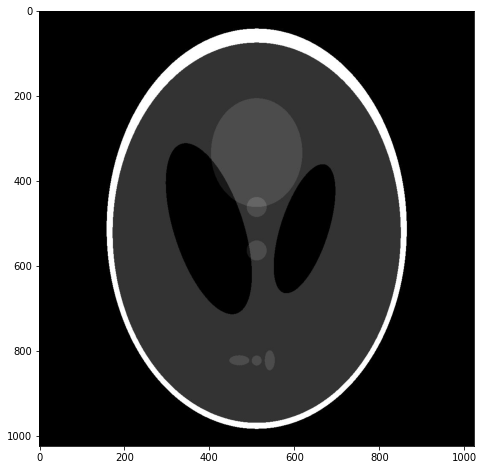

In [61]:
input_img = plt.imread(wdg_path.value)

if len(np.shape(input_img)) == 3:
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    
scans = wdg_scans.value
detectors = wdg_detectors.value
opening = wdg_opening.value
kernel_size = wdg_kernel_size.value
display_steps = wdg_display_steps.value

print(scans, detectors, opening, kernel_size, display_steps)

plt.imshow(input_img, cmap = 'gray')
plt.show()

### Finding the circle described over an image

In [62]:
# Image shape
img_heigth, img_width = np.shape(input_img)
print("Shape:", img_heigth, img_width)

# Center of mass
cx = int(img_heigth / 2)
cy = int(img_width / 2)
print("Center:", cx, cy)

# Radius
radius = int(np.floor(0.5 * np.sqrt(img_heigth**2 + img_width**2)))
print("Radius:", radius)

Shape: 1024 1024
Center: 512 512
Radius: 724


### Scanning

In [63]:
# Progress bar widget
wdg_scanning_progress = widgets.FloatProgress(value=0, min=0,max=scans,description='Progress:',bar_style='success',style={'bar_color': 'blue'},orientation='horizontal')
display(wdg_scanning_progress)

alpha = 360 / scans
step = alpha
n = detectors
l = opening

shots = []
E = []
D = []

sinogram = []
sinogram_shots = []

# Prepare preview image so that emitters and detectors will be seen
border_width = max(2 * radius - img_width, 2 * radius - img_heigth)
preview_img = deepcopy(input_img)
preview_img = cv2.cvtColor(preview_img,cv2.COLOR_GRAY2RGB)
preview_img = cv2.copyMakeBorder(preview_img, border_width, border_width, border_width, border_width, cv2.BORDER_CONSTANT, value = (0,0,0))

for s in range(scans):
    wdg_scanning_progress.value = s
    
    if s == 0:
        sinogram_shots.append(np.zeros((scans, n)))
    else:
        sinogram_shots.append(deepcopy(sinogram_shots[-1]))
    
    if display_steps:
        shots.append(deepcopy(preview_img))
        cv2.circle(shots[-1], (cx + border_width, cy + border_width), radius, (255,0,255), 1)

    # Calculating emiter's position
    xe = radius * np.cos(np.deg2rad(alpha))
    ye = radius * np.sin(np.deg2rad(alpha))

    E.append((int(cx + xe), int(cy + (-1)*ye)))

    # Drawing emiter over an image
    if display_steps:
        cv2.circle(shots[-1], (E[-1][0] + border_width, E[-1][1] + border_width), 7, (0,255,0), 3)

    D.append([])
    sinogram.append([])

    for i in range(n):
        # Calculating detector's position
        xd = radius * np.cos(np.deg2rad(alpha + 180 - l / 2 + i * (l / (n-1))))
        yd = radius * np.sin(np.deg2rad(alpha + 180 - l / 2 + i * (l / (n-1))))

        D[-1].append((int(xd + cx), int((-1)*yd + cy)))

        # Drawing detector on the image
        if display_steps:
            cv2.circle(shots[-1], (D[-1][-1][0] + border_width, D[-1][-1][1] + border_width), 3, (255,0,0), 1)

        # Calculating points of the line
        line_x_points, line_y_points = line_nd(E[-1], D[-1][-1])

        brightness = 0
        sumof = 0

        for (x, y) in zip(line_x_points, line_y_points):
            # Drawing line on the image
            if display_steps:
                cv2.circle(shots[-1], (x + border_width, y + border_width), 0, (0,0,255), -1)

            # Calculating mean brightness
            if x >= 0 and x < img_heigth and y >= 0 and y < img_width:
                brightness += input_img[x][y]
                sumof += 1

        # Adding results to sinogram
        if sumof != 0:
            brightness = brightness / sumof
        else:
            brightness = 0
        sinogram[-1].append(brightness)
        sinogram_shots[-1][s][i] = brightness

    alpha += step

FloatProgress(value=0.0, bar_style='success', description='Progress:', max=270.0, style=ProgressStyle(bar_colo…

### Scannig step by step

In [64]:
def display_shot(n):
    plt.subplot(1,2,1)
    plt.imshow(shots[n])
    plt.subplot(1,2,2)
    plt.imshow(sinogram_shots[n], cmap='gray')
    plt.show()
    
if display_steps:
    widgets.interact(display_shot, n = (0, scans - 1, 1))

interactive(children=(IntSlider(value=134, description='n', max=269), Output()), _dom_classes=('widget-interac…

### Sinogram

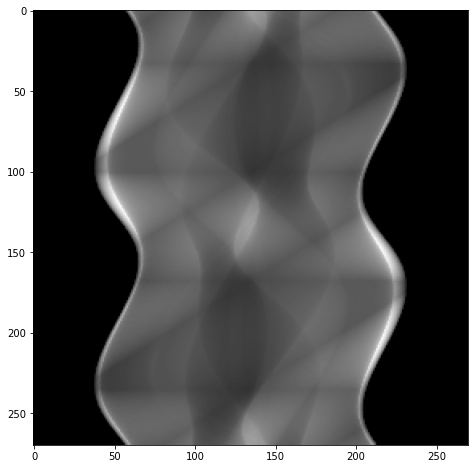

In [65]:
plt.imshow(sinogram, cmap='gray')
plt.show()

### Sinogram filtration

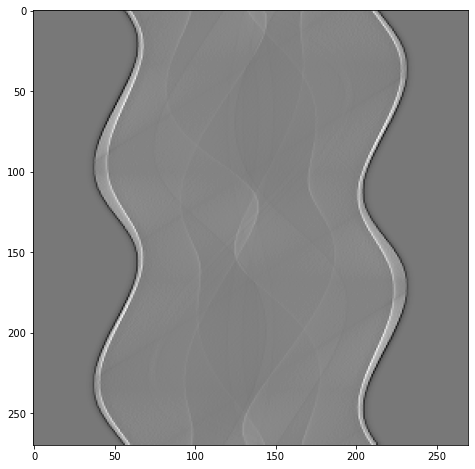

In [66]:
sinogram = np.array(sinogram)

kernel = []
for k in range(-int(np.floor(kernel_size/2)), int(np.ceil(kernel_size/2))):
    if k == 0:
        kernel.append(1)
    else:
        if k % 2 == 0:
            kernel.append(0)
        else:
            kernel.append((-4 / np.pi**2)/(k**2))

# plt.plot([k for k in range(kernel_size)], kernel)
# plt.show()

for i in range(len(sinogram)):
    sinogram[i] = np.convolve(sinogram[i], kernel, mode='same')
    
# min_brightness = sinogram.min()

# plt.imshow(sinogram, cmap='gray')
# plt.show()
    
# for i in range (len(sinogram)):
#     for j in range(len(sinogram[i])):
#         if sinogram[i][j] != 0:
#             sinogram[i][j] += abs(min_brightness)

# kernel = np.array([[-1,-1,-1], [-1,5,-1], [-1,-1,-1]])
# sinogram = cv2.filter2D(sinogram, -1, kernel)

plt.imshow(sinogram, cmap='gray')
plt.show()


### Backtracing

In [67]:
backshots = []
blank_image = np.zeros((img_heigth, img_width))

wdg_backtracing_progress = widgets.FloatProgress(value=0, min=0,max=len(sinogram),description='Progress:',bar_style='success',style={'bar_color': 'blue'},orientation='horizontal')
display(wdg_backtracing_progress)

for i in range(len(sinogram)):
    wdg_backtracing_progress.value = i
    if i == 0:
        backshots.append(deepcopy(blank_image))
    else:
        backshots.append(deepcopy(backshots[-1]))
    for j in range(n):
        line_x_points, line_y_points = line_nd(E[i], D[i][j])
        for (x, y) in zip(line_x_points, line_y_points):
            # Calculating mean brightness
            if x >= 0 and x < img_heigth and y >= 0 and y < img_width:
                backshots[-1][x][y] += sinogram[i][j]


FloatProgress(value=0.0, bar_style='success', description='Progress:', max=270.0, style=ProgressStyle(bar_colo…

### Backstracking step by step

In [68]:
def display_backshot(n):
    plt.imshow(backshots[n-1], cmap = 'gray')
    plt.show()
    plt.imshow(rescale_intensity(backshots[n-1],  (0,255)), cmap = 'gray')
    plt.show()
    
if display_steps:
    widgets.interact(display_backshot, n = (1, scans, 1))
else:
    plt.imshow(backshots[-1], cmap = 'gray')
    plt.show()

interactive(children=(IntSlider(value=135, description='n', max=270, min=1), Output()), _dom_classes=('widget-…

### Save as DICOM

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.92565844300319271982015926656412906615
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.2.2'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0020) Study Date                          DA: '20030903'
(0008, 0030) Study Time                          TM: '153014'
(0008, 0050) Accession Number                    SH: '123'
(0008, 0090) Referri

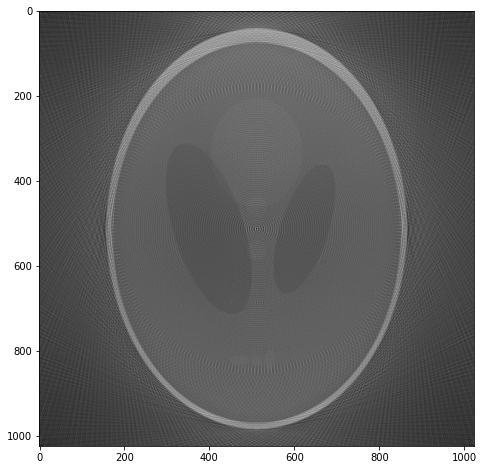

In [69]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

# https://stackoverflow.com/questions/14350675/create-pydicom-file-from-numpy-array
# https://pydicom.github.io/pydicom/dev/auto_examples/input_output/plot_write_dicom.html#sphx-glr-auto-examples-input-output-plot-write-dicom-py

img = backshots[-1].astype(np.uint16)

#meta information
file_meta = pydicom.Dataset()
file_meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

#create datase
ds = Dataset()
ds.file_meta = file_meta
ds.is_little_endian = True
ds.is_implicit_VR = False
ds.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage

#Required DICOM Tags (https://www.pclviewer.com/help/required_dicom_tags.htm)
#Study date 0008 0020
ds.add_new([0x0008, 0x0020], 'DA', '20030903')
#Study time 0008 0030
ds.add_new([0x0008, 0x0030], 'TM', '153014')
#Patient's ID 0010 0020
ds.PatientID = '123'
#Study ID 0020 0010
ds.add_new([0x0020, 0x0010], 'SH', '123')
#Series number 0020 0011
ds.add_new([0x0020, 0x0011], 'IS', '123')
#Accession Number 0008 0050
ds.add_new([0x0008, 0x0050], 'SH', '123')
#Referring Physician's Name 0008 0090
ds.add_new([0x0008, 0x0090], 'PN', 'Kaczmarek Fredrych')
#Patient's name 0010 0010
ds.PatientName = "Jan Kowalski"
#Patient's date of birth 0010 0030
ds.add_new([0x0010, 0x0030], 'DA', '20000903')
#Patient's sex 0010 0040
ds.add_new([0x0010, 0x0040], 'CS', 'male')
#Patient orientation 0020 0020
ds.add_new([0x0020, 0x0020], 'CS', 'heterosexual')

ds.SeriesInstanceUID = pydicom.uid.generate_uid()
ds.StudyInstanceUID = pydicom.uid.generate_uid()
ds.FrameOfReferenceUID = pydicom.uid.generate_uid()
ds.BitsStored = 16
ds.BitsAllocated = 16
ds.SamplesPerPixel = 1
ds.HighBit = 15
ds.ImagesInAcquisition = "1"
ds.Rows = img.shape[0]
ds.Columns = img.shape[1]
ds.InstanceNumber = 1
ds.ImagePositionPatient = r"0\0\1"
ds.ImageOrientationPatient = r"1\0\0\0\-1\0"
ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"
ds.RescaleIntercept = "0"
ds.RescaleSlope = "1"
ds.PixelSpacing = r"1\1"
ds.PhotometricInterpretation = "MONOCHROME2"
ds.PixelRepresentation = 1
pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
ds.PixelData = img.tobytes()

#saving file
ds.save_as("result.dcm", write_like_original=False)

#print information
print(ds)

#show image
plt.imshow(ds.pixel_array, cmap = 'gray')

### RMSE

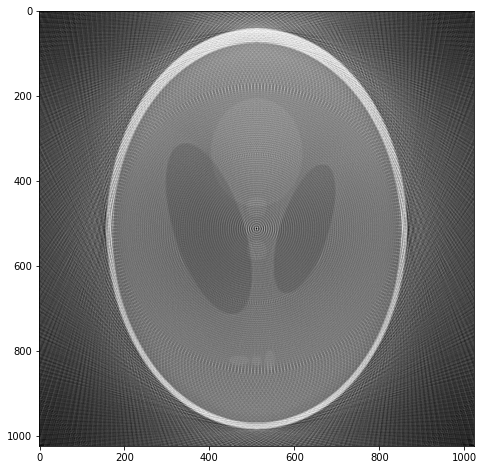

RMSE: 62.54135678100776


In [71]:
#https://stackoverflow.com/questions/20271479/what-does-it-mean-to-get-the-mse-mean-error-squared-for-2-images
#https://pl.wikipedia.org/wiki/B%C5%82%C4%85d_%C5%9Bredniokwadratowy - RMSE to pierwiastek z MSE

final_result = rescale_intensity(backshots[-1], (0,255))
# final_result = backshots[n-1]
plt.imshow(final_result, cmap ="gray")
plt.show()

RMSE = 0
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        RMSE += (input_img[i][j] - final_result[i][j])**2
RMSE = RMSE / (input_img.shape[0]*input_img.shape[1])
RMSE = RMSE**(0.5)
print("RMSE:", RMSE)

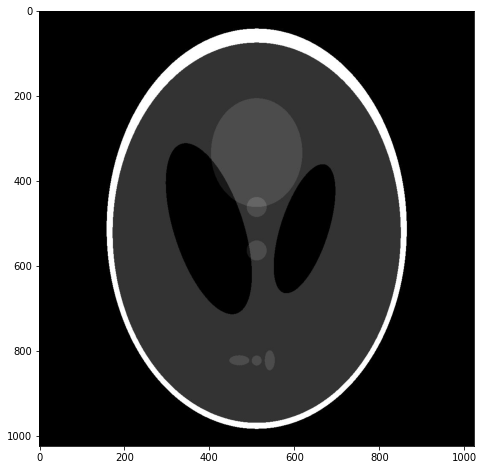

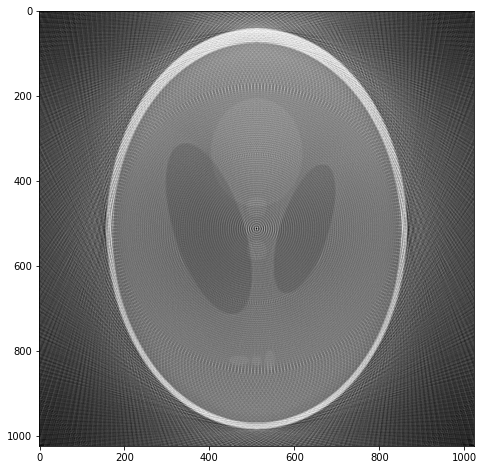

RMSE:  62.54135678100776


In [76]:
RMSE = 0
input_img = rescale_intensity(input_img, (0,255))
final_result = rescale_intensity(backshots[-1], (0, 255))

plt.imshow(input_img, cmap="gray")
plt.show()
plt.imshow(final_result, cmap="gray")
plt.show()

for i in range (len(input_img)):
    for j in range(len(input_img[i])):
        RMSE += (input_img[i][j] - final_result[i][j])**2
RMSE = RMSE / (len(input_img) * len(input_img[0]))
print("RMSE: ", np.sqrt(RMSE))